# Predicting Heart Disease In Hungary (Group 73)

## Part 1: Introduction

Heart disease is a broad term that refers to abnormal heart conditions. What identifies them as heart disease is their effect on blood flow and dilation of veins to the heart. All forms of heart disease affect a large amount of the population and they can all be extremely deadly. According to the United States Center for Disease Control (CDC), heart disease killed approximately 697,000 people in the U.S. in 2020 and is the “leading cause of death for men, women, and people of most racial and ethnic groups in the United States.” In addition to the severe impact on people’s lives and the health of the overall population, preventing and treating heart disease also has a large financial impact. According to the CDC, “heart disease cost[s] the United States about $229 billion each year [which] includes the cost of health care services [and] medicines.” 

If it could be possible to provide a model that could accurately identify heart disease in patients, this could allow for a more efficient system to identify and quickly treat heart disease (which could possibly lead to fewer deaths), and it could possibly cause the need for fewer healthcare professionals and fewer medical tests which would lower the overall financial costs as well. 

Our project aims to predict whether a person is at risk of a heart disease given data collected from medical tests on a few specific risk factors. The factors we used to predict are:

1. ST Depression
2. Chest Pain
3. Sex
4. Resting Blood Pressure

The data was taken from the UCI Machine Learning Repository's Heart Disease Dataset and was used to train our model to predict whether someone has heart disease based on the 4 risk factors listed above. Our model will diagnose heart disease based on the percentage of narrowing in major arteries (<50% meaning that the patient does NOT have heart disease and >50% meaning that the patient DOES have heart disease).

The directory was retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. There are four databases: Cleveland, Hungary, Long Beach (California), and Switzerland. The Hungarian data was chosen due to its binary column indicating whether a person is likely to have heart disease. The dataset was collected from the Hungarian Institute of Cardiology in Budapest.


## Part 2: Methods & Results

We will build the classification model using k-nearest neighbors method, train it using the training data (hungarian_train), and test it for accuracy using the testing data (hungarian_test). The predictor variables will be converted into a double data type (not factor data type) and standardized so that no one variable will have more effect on the model than others. With cross-validation the k number will be chosen to be the highest accuracy on the validation data. Then, we visualize the tuning using cross-validation by plotting a graph with number of k vs accuracy. 

## 2.1: Data Exploration

Attach the libraries and set the seed:

In [1]:
# Attach the libraries.
library(tidyverse)
library(tidymodels)
library(cowplot)
library(GGally)
library(RColorBrewer)
set.seed(1000)
options(repr.plot.width = 12, repr.plot.height = 8)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6      v purrr   0.3.4 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.1 
v readr   2.1.2      v forcats 0.5.2 

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

-- Attaching packages ----------------------------

Load the hungarian heart disease dataset and set proper column names:

In [19]:
# load hungarian heart disease dataset from database

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
column_names <- c('age', 
                  'sex', 
                  'chest_pain', 
                  'resting_blood_pressure', 
                  'cholesterol',
                  'fasting_blood_sugar', 
                  'resting_ecg', 
                  'max_heart_rate', 
                  'exercise_induced_angina',
                  'st_depression', 
                  'peak_st_slope', 
                  'major_vessel_num', 
                  'thal', 
                  'diagnosis')


hungarian_data <- read_csv(url, col_names = column_names)
glimpse(hungarian_data)

Rows: 294 Columns: 14
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (9): resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_e...
dbl (5): age, sex, chest_pain, st_depression, diagnosis

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 294
Columns: 14
$ age                     <dbl> 28, 29, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34~
$ sex                     <dbl> 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1~
$ chest_pain              <dbl> 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 4, 2, 2~
$ resting_blood_pressure  <chr> "130", "120", "140", "170", "100", "105", "110~
$ cholesterol             <chr> "132", "243", "?", "237", "219", "198", "225",~
$ fasting_blood_sugar     <chr> "0", "0", "0", "0", "0", "0", "0", "0", "0", "~
$ resting_ecg             <chr> "2", "0", "0", "1", "1", "0", "0", "0", "0", "~
$ max_heart_rate          <chr> "185", "160", "170", "170", "150", "165", "184~
$ exercise_induced_angina <chr> "0", "0", "0", "0", "0", "0", "0", "0", "0", "~
$ st_depression           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ peak_st_slope           <chr> "?", "?", "?", "?", "?", "?", "?", "?", "?", "~
$ major_vessel_num        <chr> "?", "?", "?", "?", "?", "?", "?", "?", "?", "~
$ thal            

Figure 2.1.1: The initial dataset with the correct column names.

We removed peak_st_slope, major_vessel_num, and thal because of the lack of observations in those columns. Adding them into the model will drop the amount of observations we have to work with from around 300 rows into less than 100.

Clean the dataset and select out the columns we don't need for our model:

In [20]:
hungarian_clean <- hungarian_data |>
    select(-peak_st_slope, -major_vessel_num, -thal) |> # Remove the unused columns in the dataset
    mutate(diagnosis = as_factor(diagnosis)) # Change the diagnosis column to factor so that it can be used as the predicted result.

# Mutate the data frame so that all of the numerical predictors are doubles rather than characters.             
as_double <- c("sex", 
               "chest_pain", 
               "resting_blood_pressure", 
               "cholesterol",
               "fasting_blood_sugar", 
               "resting_ecg", 
               "max_heart_rate", 
               "exercise_induced_angina", 
               "st_depression" 
               )

hungarian_clean[as_double] <- lapply(hungarian_clean[as_double], as.double)

#Get rid of any rows with NA
hungarian_clean <- hungarian_clean |>
           filter_all(all_vars(!is.na(.)))

# View the cleaned dataframe.
glimpse(hungarian_clean)

Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"
Warning message in lapply(hungarian_clean[as_double], as.double):
"NAs introduced by coercion"


Rows: 261
Columns: 11
$ age                     <dbl> 28, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35~
$ sex                     <dbl> 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1~
$ chest_pain              <dbl> 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 4, 2, 2, 2~
$ resting_blood_pressure  <dbl> 130, 120, 170, 100, 105, 110, 125, 120, 130, 1~
$ cholesterol             <dbl> 132, 243, 237, 219, 198, 225, 254, 298, 161, 2~
$ fasting_blood_sugar     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ resting_ecg             <dbl> 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0~
$ max_heart_rate          <dbl> 185, 160, 170, 150, 165, 184, 155, 185, 190, 1~
$ exercise_induced_angina <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ st_depression           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ diagnosis               <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~


Figure 2.1.2: The full dataset after cleaning.

Split the cleaned data into a training set and testing set (75% for training and 25% for testing). This proportion was chosen so that there is sufficient training data and testing data, both with a common convention (Timbers et al.). 

In [21]:
# Split data into training set and testing set.
hungarian_split <- initial_split(hungarian_clean, prop = 0.75, strata = diagnosis)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

Figure 2.1.3: The training dataset and the testing dataset after the initial split.

Create an exploratory data analysis table using the training dataset. For each diagnosis (0 being "no heart disease" and 1 being "having heart disease"), we show 3 valuable pieces of information: the total number of data points in our dataset (n_row), the percentage out of the total number of data points (percentage_of_total_data), The average of all predictor variables. 

In [22]:
hungarian_training_explore <- hungarian_train |>
            group_by(diagnosis)|>
            summarize(n_row = n(),
                      percentage_of_total_data = n()*100/nrow(hungarian_train))

hungarian_training_explore

diagnosis,n_row,percentage_of_total_data
<fct>,<int>,<dbl>
0,122,62.5641
1,73,37.4359


Figure 2.1.4: The distribution of positive and negative diagnoses in the training dataset. 

In [28]:
hungarian_training_var_mean <- hungarian_train |>
            group_by(diagnosis) |>
            summarize(across(0:10, mean))
            
hungarian_training_var_mean

diagnosis,age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,46.25410,0.6557377,2.680328,130.3033,238.0410,0.03278689,0.2868852,146.2377,0.1147541,0.1745902
1,48.90411,0.8630137,3.616438,134.6986,270.3425,0.13698630,0.2191781,130.7534,0.6027397,1.2945205


Figure 2.1.5: The mean of all variables

## Significance of Mean

Our means can give us an understanding of our data when compared to literature values. For example for cholesterol, the average cholesterol level a person not at risk of a heart disease is 238 mg/dl while the average level of a person at risk of a heart disease is 270.3 mg/dl. This helps visualize the difference in the centers of both cases. Generally, the larger the difference, the easier the model is going to predict.

## Predictor Variable Selection

We decided to tune our classifier to choose what predictor variables we will use from our data. 
The purpose is to choice variables that are relevant. We did this on our training set and used the forward selection method. 

### Our General Method

1. we start a no predictors model
2. run the following 3 steps until you run out of predictors:
* form a candidate model by adding each unused predictor to the model 
* tune all of the candidate models
* update the model to choose the candidate model with the highest cross-validation accuracy

3. select the model that provides the highest accuracy relative to its simplicity (number of predictors)

In [7]:
hungarian_subset <- hungarian_train

selection_names <- hungarian_subset |>
                select(-diagnosis) |>
                colnames()

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
selection_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
selection_vfold <- vfold_cv(hungarian_subset, v = 5, strata = diagnosis)

# store the total number of predictors
n_total <- length(selection_names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
     # for every predictor still not added yet
     accs <- list()
     models <- list()
     for (j in 1:length(selection_names)) {
         # create a model string for this combination of predictors
         preds_new <- c(selected, selection_names[[j]])
         
         model_string <- paste("diagnosis", "~", paste(preds_new, collapse="+"))
         
         # create a recipe from the model string
         selection_recipe <- recipe(as.formula(model_string), data = hungarian_subset) |>
             step_scale(all_predictors()) |>
             step_center(all_predictors())
         
         # tune the KNN classifier with these predictors, and collect the accuracy for the best K
         acc <- workflow() |>
             add_recipe(selection_recipe) |>
             add_model(selection_spec) |>
             tune_grid(resamples = selection_vfold, grid = 10) |>
             collect_metrics() |>
             filter(.metric == "accuracy") |>
             summarize(max_acc = max(mean))
         
         acc <- acc$max_acc |>
                unlist()
         
         # add this result to the dataframe
         accs[[j]] <- acc
         models[[j]] <- model_string
     }
     jstar <- which.max(unlist(accs))
     accuracies <- accuracies |>
                add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
     selected <- c(selected, selection_names[[jstar]])
     selection_names <- selection_names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,diagnosis ~ st_depression,0.7808165
2,diagnosis ~ st_depression+chest_pain,0.8110729
3,diagnosis ~ st_depression+chest_pain+sex,0.8263360
4,diagnosis ~ st_depression+chest_pain+sex+resting_blood_pressure,0.8514575
5,diagnosis ~ st_depression+chest_pain+sex+resting_blood_pressure+cholesterol,0.8464575
6,diagnosis ~ st_depression+chest_pain+sex+resting_blood_pressure+cholesterol+age,0.8517206
7,diagnosis ~ st_depression+chest_pain+sex+resting_blood_pressure+cholesterol+age+fasting_blood_sugar,0.8513225
8,diagnosis ~ st_depression+chest_pain+sex+resting_blood_pressure+cholesterol+age+fasting_blood_sugar+max_heart_rate,0.8368556
9,diagnosis ~ st_depression+chest_pain+sex+resting_blood_pressure+cholesterol+age+fasting_blood_sugar+max_heart_rate+resting_ecg,0.8522537


Figure 2.1.6: Predictor variables and their effect on accuracy

Based on the predictor variable selection, the top 4 variables that increase the accuracy of our model seem to be:
1. ST Depression
2. Chest Pain
3. Sex
4. Resting Blood Pressure

Therefore, we shall use these 4 variables as predictors for our model.

We use ggpairs from the GGally package in order to display the correlations between our four predictors and show their correlations to our diagnosis variable. The red is a 0 (no heart disease) and the blue is a 1 (heart disease). 

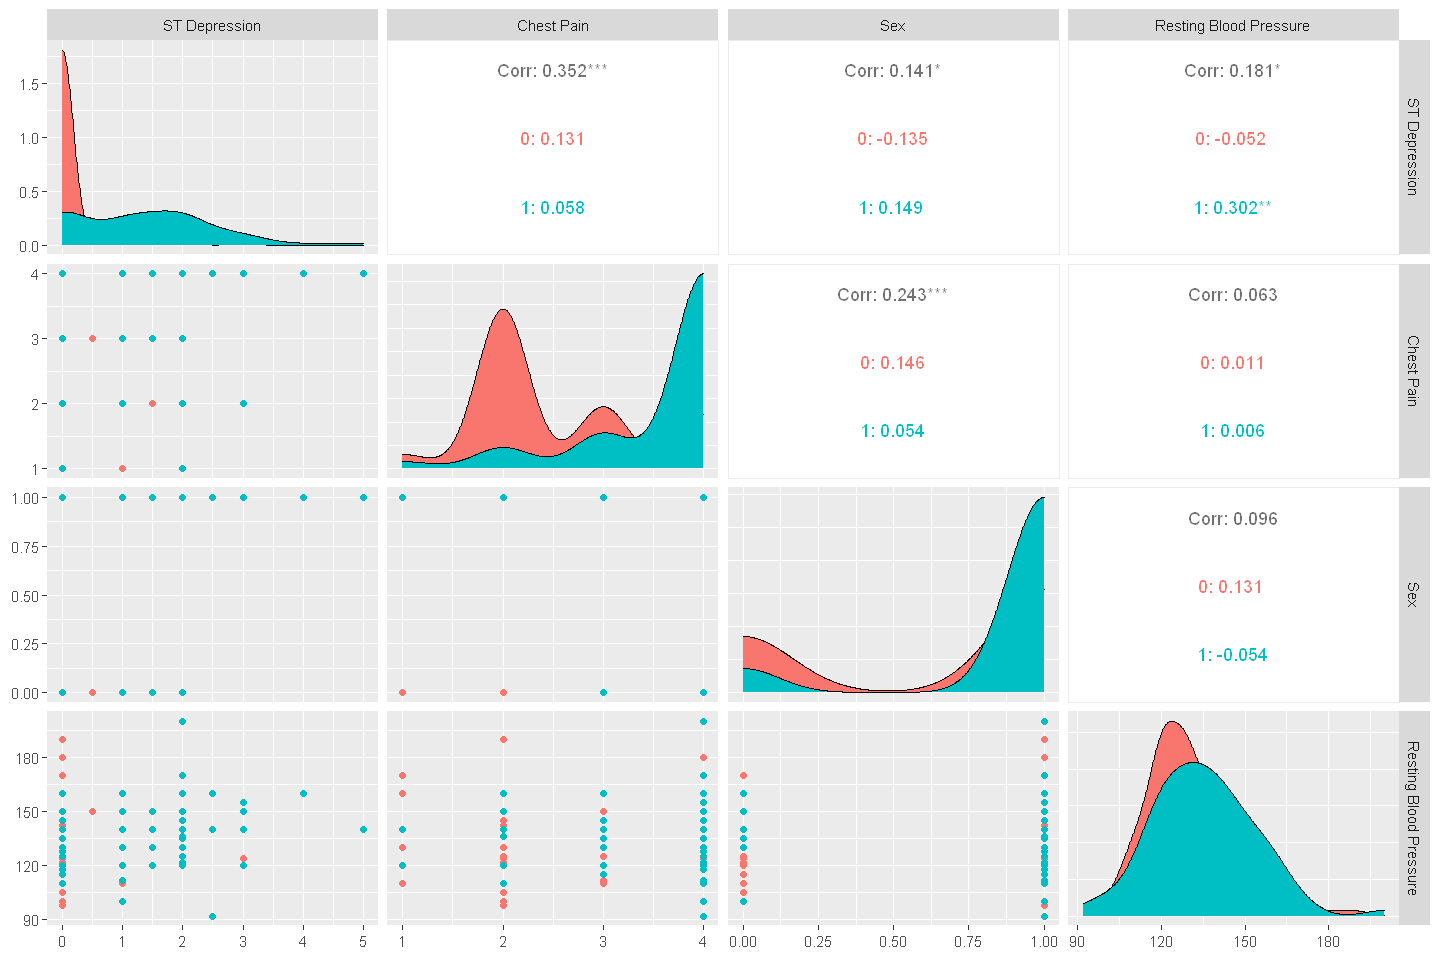

In [8]:
# Display our predictors and their correlations with one another.
library(GGally)
training_correlations <- hungarian_train |>
    ggpairs(columns = c("st_depression", 
                        "chest_pain", 
                        "sex", 
                        "resting_blood_pressure"), 
            ggplot2::aes(colour=diagnosis), 
            columnLabels = c("ST Depression",
                             "Chest Pain", 
                             "Sex",
                             "Resting Blood Pressure")
           )

training_correlations

Figure 2.1.7: How each predictor relates to other predictors and to the diagnosis.

From the values plotted by the ggpairs function, it can be seen that chest pain and st depression have the highest correlation of 0.352, with sex and chest pain having the second highest correlation of 0.243, and the remaining has a correlation between the interval 0.063 to 0.181. Nonetheless, since the correlations are positive, it indicates that increasing st depression, chest pain, sex, or resting blood pressure may have a higher heart disease chances. In addition, looking at the four graphs, it can be seen that sex and resting blood pressure will have a less significant contribution when determining chances of having heart disease as when the data varies, the chances of having heart diseases shows a similar trend and behavior, making it hard to distinguish the affects on heart disease of the two variables. This also shows that the order of the predictor variables makes sense. The more distinguished the spread of the predictor variable distribution of each prediction, the better our model will be able to use them to create a prediction.

Visualizing distribution of predictor variables:

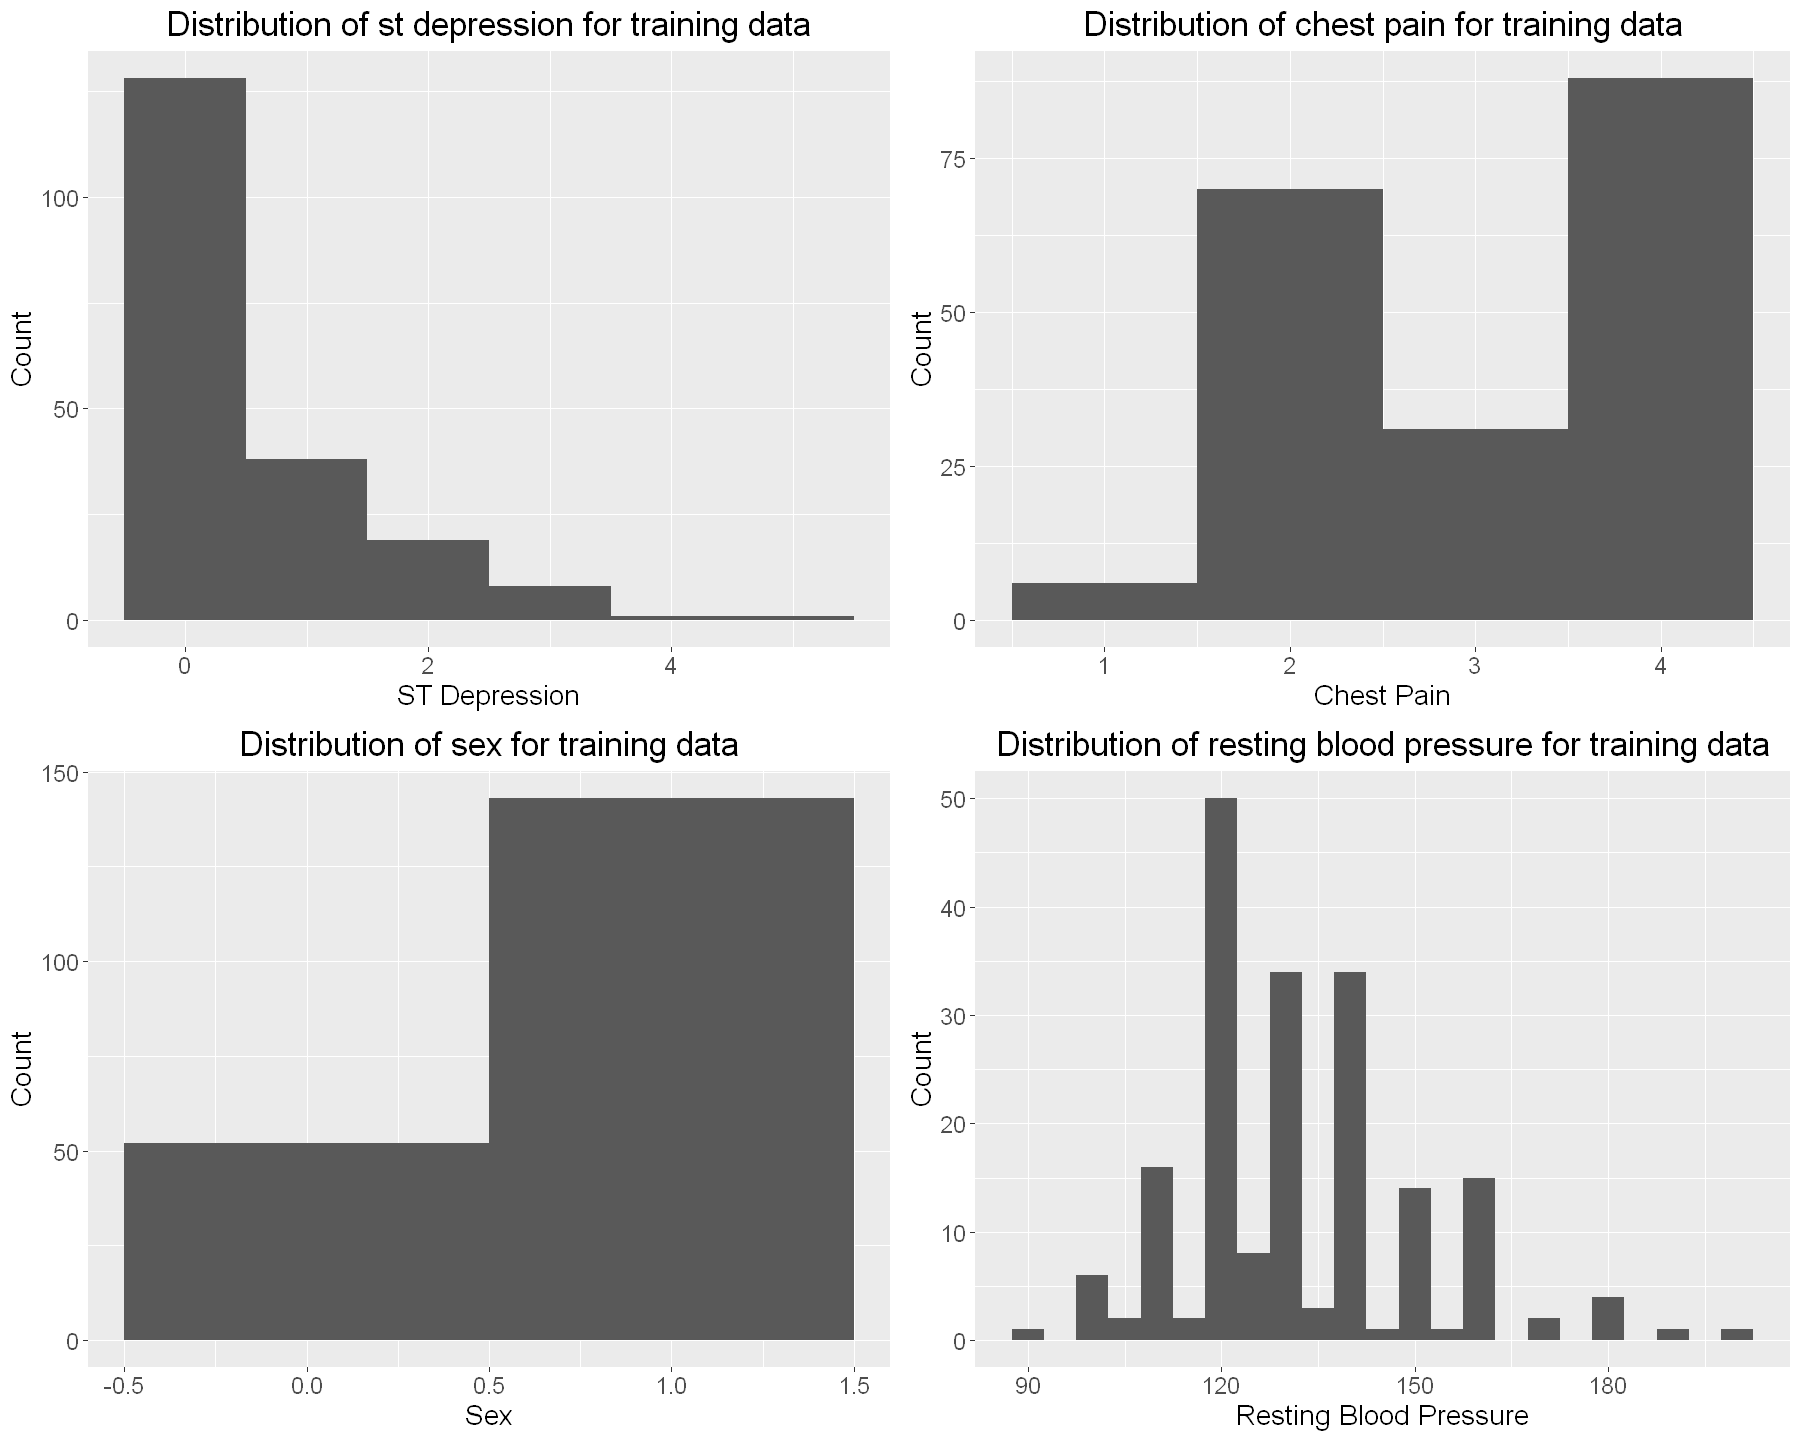

In [49]:
options(repr.plot.width = 15, repr.plot.height = 12)

training_st_depression_plot <- hungarian_train |>
                ggplot(aes(x=st_depression))+
                geom_histogram(binwidth=1)+
                labs(x="ST Depression", y="Count")+
                ggtitle("Distribution of st depression for training data")+
                theme(text=element_text(size=17), plot.title=element_text(hjust=0.5))

training_chest_pain_plot <- hungarian_train |>
                ggplot(aes(x=chest_pain))+
                geom_histogram(binwidth=1)+
                labs(x="Chest Pain", y="Count")+
                ggtitle("Distribution of chest pain for training data")+
                theme(text=element_text(size=17), plot.title=element_text(hjust=0.5))

training_sex_plot <- hungarian_train |>
                ggplot(aes(x=sex))+
                geom_histogram(binwidth=1)+
                labs(x="Sex", y="Count")+
                ggtitle("Distribution of sex for training data")+
                theme(text=element_text(size=17), plot.title=element_text(hjust=0.5))

training_resting_blood_pressure_plot <- hungarian_train |>
                ggplot(aes(x=resting_blood_pressure))+
                geom_histogram(binwidth=5)+
                labs(x="Resting Blood Pressure", y="Count")+
                ggtitle("Distribution of resting blood pressure for training data")+
                theme(text=element_text(size=17), plot.title=element_text(hjust=0.5)) 

hungarian_training_plot <- plot_grid(training_st_depression_plot,
                                     training_chest_pain_plot, 
                                     training_sex_plot,
                                     training_resting_blood_pressure_plot,
                                     ncol=2)

hungarian_training_plot

Figure 2.1.8: Distribution of predictor variables

## 2.2: Data Analysis

In [10]:
hungarian_recipe <- recipe(diagnosis ~ st_depression + chest_pain + sex + resting_blood_pressure, data = hungarian_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

hungarian_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In the initialized recipe, we set the diagnosis as our target variable while setting age, resting blood pressure, cholesterol, and max heart rate to be our predictors. The predictors were then standardized (scaled and centered) to have a mean of 0 and a standard deviation of 1.

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We create the model specification here. We use the k nearest neighbor algorithm and set it to tune the neighbors. We set the engine to be k nearest neighbors and the mode to classification, as this is a k nearest neighbor classification problem. 

In [12]:
hungarian_vfold <- vfold_cv(hungarian_train, v = 5, strata = diagnosis)

Doing cross-validation in k-nearest neighbour classification will allow the best k to be picked accordingly to the accuracy that each k results in, where the k that gives the highest prediction accuracy will be chosen. 5-fold cross-validation tunes the model by splitting the overall training data into 5 even-sized groups, in which while 1 group of data is used as the validation set, the other 4 remaining groups are used as the training set. This process was then repeated 5 times (Timbers et al.).

In [13]:
k_tibble <- tibble(neighbors = seq(from = 1, to = 31, by = 2))

In [14]:
results <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = hungarian_vfold, grid = k_tibble) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7645074,5,0.02584096,Preprocessor1_Model01
3,accuracy,binary,0.7951552,5,0.02758965,Preprocessor1_Model02
5,accuracy,binary,0.8152834,5,0.01535816,Preprocessor1_Model03
7,accuracy,binary,0.8405466,5,0.02299331,Preprocessor1_Model04
9,accuracy,binary,0.8252901,5,0.02135079,Preprocessor1_Model05
11,accuracy,binary,0.8301552,5,0.02754039,Preprocessor1_Model06
13,accuracy,binary,0.8306815,5,0.01347450,Preprocessor1_Model07
15,accuracy,binary,0.8351552,5,0.02775941,Preprocessor1_Model08
17,accuracy,binary,0.8508097,5,0.01804755,Preprocessor1_Model09


Figure 2.2.1: A table of the accuracies of each K found through cross-validation.

After combining the recipe and the model specification into a workflow and filtering the workflow to contain only our desired metric variable (accuracy), the estimated accuracy can be observed for each possible k we have previously chosen to test. 

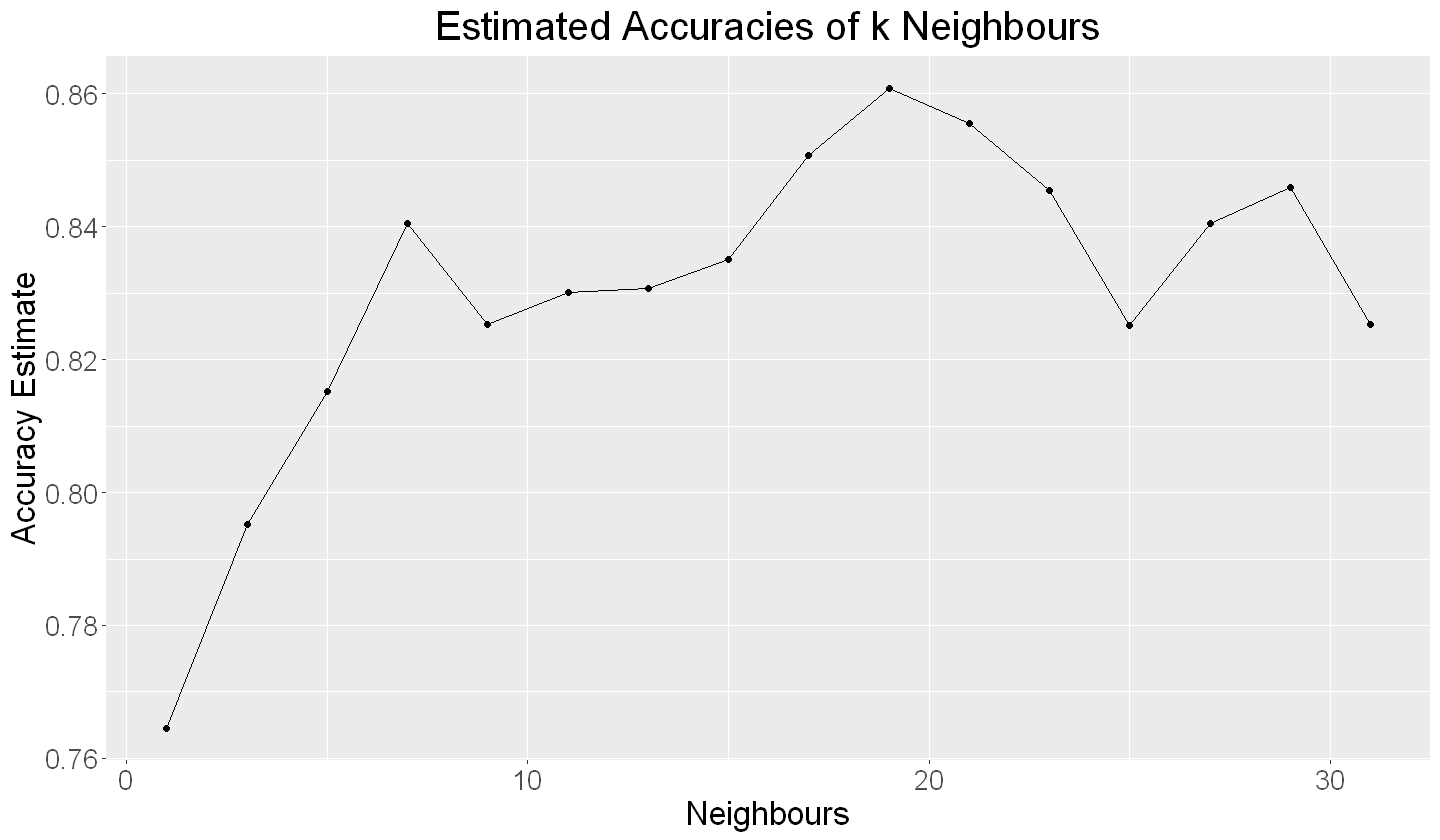

In [15]:
options(repr.plot.width = 12, repr.plot.height = 7)

cross_val_plot <- results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Estimated Accuracies of k Neighbours") +
    theme(text = element_text(size=20), plot.title = element_text(hjust=0.5))

cross_val_plot

Figure 2.2.2: An plot showing accuracy and K neighbours. From this plot it is clear that the best K is 19.

In [16]:
best_k <- results |>
    filter(mean == max(mean)) |>
    pull(neighbors)

best_k

[1] 19

Visualizing the variance of estimated accuracies of the different number of k neighbours, and observed that there is a "peak" at 19 where the accuracy stops increasing dramatically and begins to level down or start to decrease (Timbers et al.). 

In order to get a more accuracy number for k, we filtered the previous workflow that stored the estimated accuracy of each of the picked k to get the k that has the maximum accuracy mean.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



.metric,.estimate
<chr>,<dbl>
accuracy,0.7878788


          Truth
Prediction  0  1
         0 33  6
         1  8 19

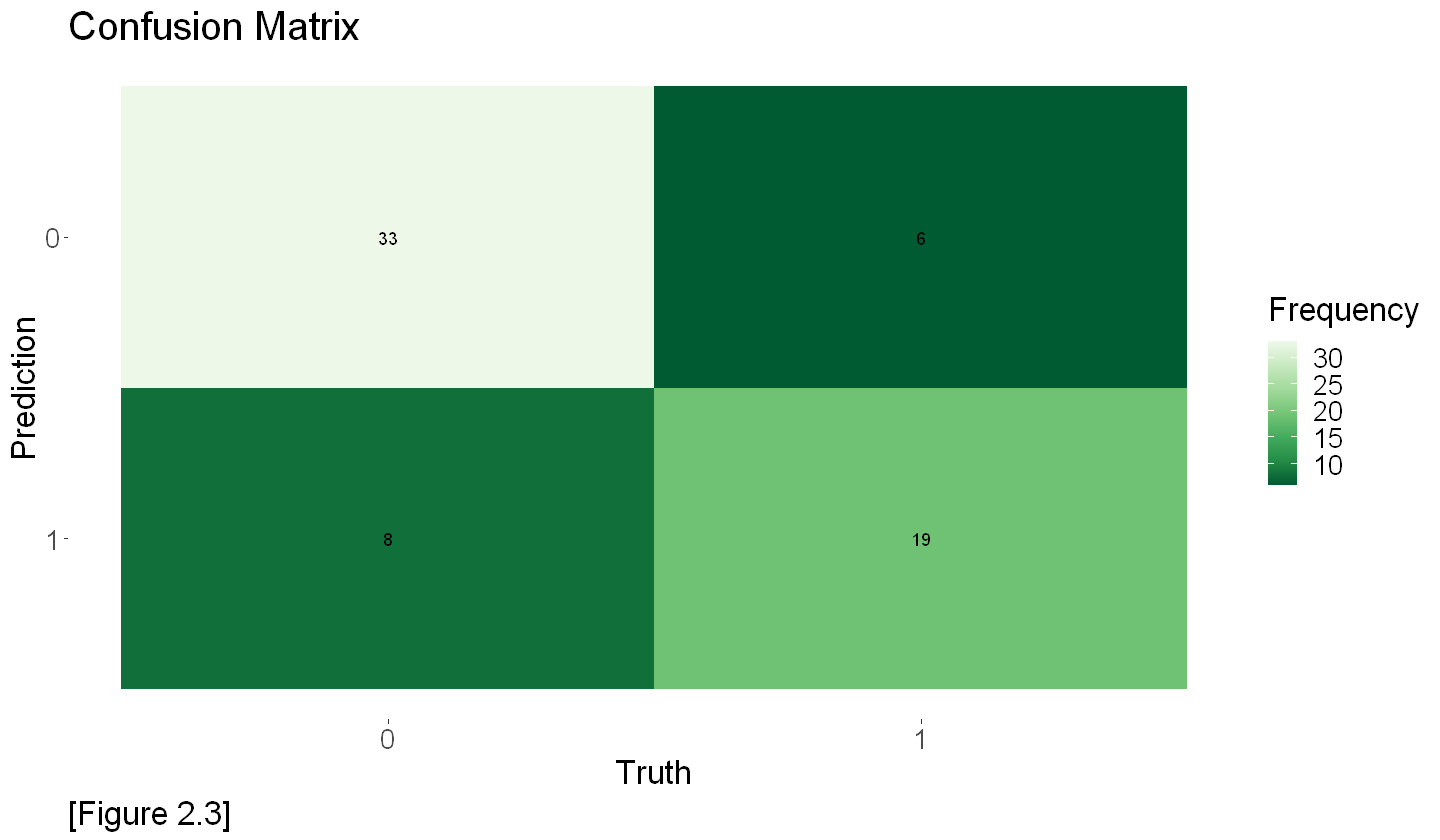

In [17]:
# Create nearest neighbor model with best number of k
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit the model and recipe into training data
hungarian_fit <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = hungarian_train)

# Get the prediction column
hungarian_predictions <- predict(hungarian_fit, hungarian_test) |> 
    bind_cols(hungarian_test)

# Compare the accuracy of predictions to the true values in the test set
hungarian_accuracy <- hungarian_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

# Compare the predictions to the true values in a confusion matrix
hungarian_comparison <- hungarian_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

autoplot(hungarian_comparison, type = "heatmap") + #friendly for color blind  
labs(title = "Confusion Matrix", caption = "[Figure 2.3]") +
scale_fill_distiller(palette = "Greens", name = "Frequency") + #color blind friendly
theme(legend.position = "right", text = element_text(size = 20), 
      plot.caption = element_text(size = 20, hjust = 0))


hungarian_accuracy
hungarian_comparison


Figure 2.2.3: Accuracy tibble and prediction of testing data matrix

## Part 3: Discussion


Our model achieved a 78.79% accuracy level as depicted in the table (need name of accuracy table). Initially we didn't think sex would have a significant impact on our model but after further research we learned that men are twice as likely to develop heart disease possibly due to men being less adaptive to cope with stressful events. This variable's connection with societal expectations of dealing with emotion was an interesting connection (“Throughout Life, Heart Attacks”). Thus future studies on running this model again but only with a specific sex would be interesting.

We decided to not use one predictor as this can lead to variability in prediction (Timbers et al.). 

Our accuracy of 78.79% is quite high for predicting heart disease. The American College of Cardiology/American Heart Association has a series of guidelines that on average is 72.8 percent accurate. The best AI model has an accuracy of 79.8%. Given our model accuracy is quite high, it is possible that factors such as (1) our limited amount of data, (2) our predictor variables having little to no correlation with what we are trying to predict, (3) overfitting our model to our training data, or (4) our data variables in training or testing being similar, could influence this high accuracy.

** Need to add how we had a total of x observations after filtering out observations labeled “N.A.” and before splitting the data into training and testing. Then, after doing the initial split, we had a training dataset with only xxxxx observations and a testing dataset with only xxxx observations.

Second, our dataset showed little correlation between predictors and the prediction overall. From Figure 2.1.5, it is clear that none of our predictors have a clear correlation with whether or not someone has heart disease (based on this dataset) because the red and blue points (red equaling “no heart disease” and blue equaling “heart disease”) are not located in concise clusters in any of these experimental graphs. Due to this, our model struggles to find patterns in the data and therefore struggles to accurately classify new data. This issue is also clear when changing the initial random seed in our analysis. If the seed changes, our results vary significantly which means that our data is not well-suited for classification. 

Future studies could be trying to build a model with universal application, especially for communities without the precise machinery or trained expertise to predict heart disease. As such, more data points would be needed. Since we only used data from hungary it is possible that this demographic has different needs, especially when Hungary has one of the highest heart disease ratings in the European Union, which could ultimately affect our data and thus our model when applied to a broader international demographic ("Deaths Due to Coronary Heart Diseases"). Additionally, combining the geogrpahical areas such as long beach (Los Angeles) that is avalible in our directory. 


This raises some ongoing questions:
1) Would we be able to find correlations between these four risk factors and heart disease if our dataset had been larger?
2) Could one of the other heart disease datasets (such as the Cleveland set) have produced better results and a more reliable model overall?
3) Will it ever be possible to diagnose patients with a high enough degree of accuracy as to eliminate the need for a medical professional?
4) Can a model be 100% accurate?




## Works Cited

CDC – Heart Disease Statistics and Maps – Heart Disease Facts. https://www.cdc.gov/heartdisease/facts.htm. December 6, 2022.

“Deaths Due to Coronary Heart Diseases in the EU.” EuroStat, 28 Sept. 2020, www.ec.europa.eu/eurostat/web/products-eurostat-news/-/edn-20200928-1. 

Tarantola, Andrew. “AI Can Predict Heart Attacks More Accurately than Doctors.” Engadget, 16 Apr. 2017, www.engadget.com/2017-04-16-ai-can-predict-heart-attacks-more-accurately-than-doctors.html. 

Timbers, Tiffany, et al. “Data Science.” Data Science, 24 Sept. 2022, datasciencebook.ca. 

“Throughout Life, Heart Attacks Are Twice as Common in Men than Women.” Harvard Health, 8 Nov. 2016, www.health.harvard.edu/heart-health/throughout-life-heart-attacks-are-twice-as-common-in-men-than-women#:~:text=Throughout%20life%2C%20heart%20attacks%20are%20twice%20as%20common%20in%20men%20than%20women,-November%208%2C%202016. 